# Import Dependencies

In [45]:
import re
import pickle
import string
import numpy as np
import pandas as pd

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.attrs import IS_ALPHA
from spacy.lang.en import English
from spacy import displacy, lemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

from wordcloud import WordCloud
from textwrap import wrap
from sklearn.manifold import TSNE

import pyLDAvis
import pyLDAvis.sklearn

# Custom functions from .py files
from web_scrape import get_transcript
from preprocess import clean, preprocess

# Import/Preprocess Data

In [3]:
# Web scrape most recent speeches using our imported 'get_transcript'
goodyear = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-goodyear-az-october-28')
bullhead = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-bullhead-city-az-october-28')
omaha = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-omaha-ne-october-27')
wsalem = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-west-salem-wisconsin-october-27')
lansing = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-lansing-michigan-october-27')
martinsburg = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-martinsburg-pa-october-26')
lititz = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-lititz-pa-october-26')
allentown = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-allentown-pa-october-26')

In [4]:
# Create corpus
corpus = [goodyear, bullhead, omaha, wsalem, lansing, martinsburg, lititz, allentown]

In [5]:
# Clean corpus using our imported 'clean' function
clean_corpus = clean(corpus)

In [6]:
# Preprocess the speeches using our imported 'preprocess' function
processed_corpus = preprocess(clean_corpus)

# Doc-Term Matrix

In [7]:
# Countvectorizer
cv = CountVectorizer(stop_words='english')

X_cv = cv.fit_transform(processed_corpus)

df_cv = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

In [47]:
df_cv

,able,abolish,abortion,abraham,absentee,absolute,absolutely,abuse,accept,acceptance,...,york,young,youtube,yu,yuma,zero,zippo,zone,zoning,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# TF_IDF
tfidf_vectorizer = TfidfVectorizer(**cv.get_params())

X_tfidf = tfidf_vectorizer.fit_transform(processed_corpus)

df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())

# LSA

In [9]:
# Latent Semantic Analysis (LSA) is just another name for Singular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
# Let's compare explained variance using each vectorizer
lsa_cv = TruncatedSVD(5)
lsa_tfidf = TruncatedSVD(5)

# Doc_topic matrices will be used later
doc_topic_cv = lsa_cv.fit_transform(X_cv)
doc_topic_tfidf = lsa_tfidf.fit_transform(X_tfidf)

total_expl_var_cv = round(sum(lsa_cv.explained_variance_ratio_), 4) * 100
total_expl_var_tfidf = round(sum(lsa_tfidf.explained_variance_ratio_), 4) * 100

print(f"Explained variance using CountVectorizer: {total_expl_var_cv}%")
print(f"Explained variance using TFIDF: {total_expl_var_tfidf}%")

Explained variance using CountVectorizer: 7.37%
Explained variance using TFIDF: 7.32%


In [22]:
# CountVectorizer has a slightly higher explained variance, so we will use this model from here on out

In [10]:
# Topic matrix
topics = pd.DataFrame(lsa_cv.components_.round(3),
             index = ["c1","c2","c3","c4","c5"],
             columns = cv.get_feature_names())
topics

,able,abolish,abortion,abraham,absentee,absolute,absolutely,abuse,accept,acceptance,...,york,young,youtube,yu,yuma,zero,zippo,zone,zoning,zucker
c1,0.005,0.005,0.001,0.005,0.0,0.000,0.010,0.002,0.0,0.0,...,0.008,0.012,0.001,0.0,0.001,0.001,0.0,0.002,0.0,-0.0
c2,0.002,0.007,0.001,-0.006,-0.0,0.000,0.000,0.000,0.0,-0.0,...,-0.001,0.011,-0.000,0.0,0.000,-0.000,0.0,-0.001,0.0,0.0
c3,0.004,0.006,0.001,0.001,0.0,-0.000,0.002,-0.001,-0.0,-0.0,...,-0.001,0.001,0.000,-0.0,-0.001,0.000,0.0,0.000,-0.0,-0.0
c4,0.000,0.001,0.000,-0.003,0.0,0.001,0.014,0.001,0.0,0.0,...,-0.003,-0.003,-0.000,0.0,0.002,0.000,0.0,0.000,0.0,-0.0
c5,-0.001,-0.001,-0.000,0.005,-0.0,0.002,0.006,-0.000,0.0,-0.0,...,-0.001,0.002,-0.000,-0.0,0.003,-0.000,-0.0,-0.000,-0.0,0.0


In [11]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [12]:
display_topics(lsa_cv, cv.get_feature_names(), 10)


Topic  0
great, want, know, people, year, like, right, country, win, china

Topic  1
want, know, right, thing, joe, talk, border, come, life, lock

Topic  2
want, great, win, people, china, year, american, country, america, border

Topic  3
right, year, win, like, china, biden, joe, president, ago, big

Topic  4
right, great, want, liberty, life, defend, speech, free, religious, bear


In [13]:
# Vt matrix
Vt = pd.DataFrame(doc_topic_cv.round(5),
             index = processed_corpus,
             columns = ["c1","c2","c3","c4","c5"])
Vt.head(10)

,c1,c2,c3,c4,c5
"deliver,record,prosperity,epic,job,growth,safe,vaccine,eradicate,virus,china,plague,quickly,end,pandemic",0.42935,-0.18741,0.11637,0.17728,-0.17644
"normal,life,want,want,normal,life",0.87281,1.34287,1.20170,-0.31314,0.27876
"like,seven,month,ago",0.28308,-0.02876,-0.14927,0.34035,-0.16278
"fully,resume,year,great,economic,power",0.68311,-0.82615,0.19158,-0.05929,-0.00855
strong,0.01877,-0.01104,0.00152,-0.00495,0.00196
happen,0.05096,0.01371,-0.03766,0.01502,-0.00894
"year,good,economic,year,country,history",0.83524,-0.53802,0.12427,0.80553,-0.52301
"year,interrupt",0.24609,-0.18539,0.04275,0.35820,-0.25810
interrupt,0.00034,-0.00035,0.00008,0.00076,-0.00057
"america,great",0.48618,-0.70081,0.16713,-0.40887,0.23327


In [14]:
topic_c1_lsa = Vt[['c1']]
topic_c1_lsa.sort_values(by='c1',ascending=False).head(10)

,c1
"year,american,dream,plan,bring,million,new,job,hispanic,community,create,half,million,new,hispanic,small,business,end,large,business,know,know,great,business,people,great,natural,business,people,expand,opportunity,federal,contracting,easy,job,increase,access,capital,billion,dollar",3.29003
"know,great,great,country,country,tremendous,potential,country,great",2.09575
"want,fighter,want,continue,fighter,proud,work,president,trump,great,american,comeback,strong,military,secure,border,second,amendment,right,girl,arizona",1.83890
"hate,war,like,hate,war,want,america,support,america,spend,money,overseas,waste,life,overseas,unwinnable,endless,war,need,support,president,state,union,great,nation,fight,perpetual,war",1.66178
"want,wind,want,windmill,germany,china,send,big,big,carbon,air,know,right",1.65677
"stand,shoulder,american,hero,cross,ocean,settle,continent,tame,wilderness,lay,railroad,raise,great,skyscraper,win,world,war,defeat,fascism,communism,america,single,great,nation,history,world",1.64124
"stand,shoulder,american,hero,cross,ocean,settle,continent,tame,wilderness,lay,railroad,raise,great,skyscraper,win,world,wars,defeat,fascism,communism,america,single,great,nation,history,world",1.62459
"want,people,want,come,country,blow,store,street,people",1.60708
"want,normal,life,year,great,economic,year,history,country",1.60565
"raise,great,skyscraper,lay,battleship,win,world,wars,defeat,fascism,communism,america,single,great,nation,history,world,good,come",1.58293


In [40]:
#cosine_similarity(Vt.head(5))

In [41]:
#cos_dtm = cosine_similarity(df_cv).round(2)
#cos_dtm

# Non-negative Matrix Factorization

In [15]:
processed_corpus
ex_label = [e[:70]+"..." for e in processed_corpus]

In [16]:
df_nmf = pd.DataFrame(X_cv .toarray(), index=ex_label, columns=cv.get_feature_names())

In [17]:
df_nmf.head(10)

,able,abolish,abortion,abraham,absentee,absolute,absolutely,abuse,accept,acceptance,...,york,young,youtube,yu,yuma,zero,zippo,zone,zoning,zucker
"deliver,record,prosperity,epic,job,growth,safe,vaccine,eradicate,virus...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"normal,life,want,want,normal,life...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"like,seven,month,ago...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"fully,resume,year,great,economic,power...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
strong...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
happen...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"year,good,economic,year,country,history...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"year,interrupt...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
interrupt...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"america,great...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
nmf_model = NMF(5)
doc_topic_nmf = nmf_model.fit_transform(X_cv)

The W matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (topic 1) seems to be about _____
- Component 2 (topic 2) seems to be about _____

In [19]:
topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
             index = ["c1","c2","c3","c4","c5"],
             columns = cv.get_feature_names())
topic_word_nmf

,able,abolish,abortion,abraham,absentee,absolute,absolutely,abuse,accept,acceptance,...,york,young,youtube,yu,yuma,zero,zippo,zone,zoning,zucker
c1,0.009,0.000,0.000,0.062,0.000,0.00,0.000,0.000,0.000,0.001,...,0.038,0.009,0.004,0.000,0.00,0.000,0.0,0.012,0.0,0.0
c2,0.023,0.040,0.008,0.000,0.000,0.00,0.017,0.002,0.000,0.000,...,0.008,0.053,0.001,0.000,0.00,0.000,0.0,0.000,0.0,0.0
c3,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.002,0.000,0.000,...,0.019,0.033,0.000,0.000,0.00,0.000,0.0,0.000,0.0,0.0
c4,0.017,0.012,0.003,0.000,0.002,0.00,0.057,0.010,0.001,0.001,...,0.014,0.008,0.000,0.002,0.00,0.005,0.0,0.007,0.0,0.0
c5,0.000,0.000,0.000,0.010,0.000,0.01,0.057,0.001,0.000,0.000,...,0.000,0.016,0.000,0.000,0.02,0.000,0.0,0.000,0.0,0.0


In [33]:
display_topics(nmf_model, cv.get_feature_names(), 10)


Topic  0
great, people, job, country, america, history, world, american, stand, nation

Topic  1
want, people, thing, border, talk, life, normal, come, million, lock

Topic  2
know, people, happen, lot, time, thing, think, big, hell, good

Topic  3
year, win, like, biden, china, vote, joe, country, think, president

Topic  4
right, liberty, big, defend, thing, speech, free, good, religious, bear


NoneType

The H matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. In this case:
- The first document seems to be about _____
- The last document seems to be about _____
- Everything in between is a combination of _____

In [22]:
H = pd.DataFrame(doc_topic_nmf.round(4),
             index = ex_label,
             columns = ["c1","c2","c3","c4","c5"])
H.head(5)

,c1,c2,c3,c4,c5
"deliver,record,prosperity,epic,job,growth,safe,vaccine,eradicate,virus...",0.0242,0.0021,0.0000,0.0992,0.0000
"normal,life,want,want,normal,life...",0.0000,0.5013,0.0000,0.0000,0.0055
"like,seven,month,ago...",0.0000,0.0000,0.0039,0.1036,0.0006
"fully,resume,year,great,economic,power...",0.1350,0.0000,0.0000,0.1037,0.0000
strong...,0.0030,0.0002,0.0007,0.0013,0.0001


In [23]:
# Let's look at each individual topic

topic_c1_nmf = H[['c1']]
topic_c1_nmf.sort_values(by='c1',ascending=False).head(10)

,c1
"know,great,great,country,country,tremendous,potential,country,great...",0.4612
"day,feel,exactly,great,mike,great,congressman,feel,exactly,great...",0.4363
"year,american,dream,plan,bring,million,new,job,hispanic,community,crea...",0.4324
"remember,guy,great,great,great...",0.4240
"stand,shoulder,american,hero,cross,ocean,settle,continent,tame,wildern...",0.3790
"stand,shoulder,american,hero,cross,ocean,settle,continent,tame,wildern...",0.3786
"raise,great,skyscraper,lay,battleship,win,world,wars,defeat,fascism,co...",0.3479
"place,generation,tough,strong,pennsylvania,worker,mind,work,railroad,f...",0.3471
"governor,talk,great,job,great,job,fight,china,virus...",0.3210
"great,job,anchor,thing,fella,great,job...",0.3204


In [24]:
topic_c2_nmf = H[['c2']]
topic_c2_nmf.sort_values(by='c2',ascending=False).head(10)

,c2
"want,vision,want,steel,want,rebar,want,concrete,inside...",0.9452
"suburban,woman,want,law,order,want,safety,want,regulation,destroy,subu...",0.7241
"want,people,want,come,country,blow,store,street,people...",0.5525
"want,people,want,kill,people...",0.5385
"drone,want,want,talk,drone,watch,thousand,people,pour,border...",0.5360
"country,want,harm,people,want,harm,stay,hell...",0.5144
"lot,people,want,tuesday,want,early...",0.5097
"okay,want,people,want,blow,country...",0.5096
"normal,life,want,want,normal,life...",0.5013
"want,knock,medicare,social,security,want,abolish,thing,american,energy...",0.4999


In [25]:
topic_c3_nmf = H[['c3']]
topic_c3_nmf.sort_values(by='c3',ascending=False).head(10)

,c3
"year,american,dream,plan,bring,million,new,job,hispanic,community,crea...",0.5094
"anonymous,disgruntle,employee,quickly,remove,job,long,time,ago,tell,co...",0.4862
"reveal,know,anonymous,know,anonymous,everybody,look...",0.4652
"let,tell,democrats,know,crooked,know...",0.4645
"know,today,like,different,know,month,ago...",0.4597
"know,thing,know...",0.4597
"man,know,body,language,man,know...",0.4578
"know,opponent,jet,know...",0.4534
"know,help,know,statement...",0.4533
"friend,know,know...",0.4523


In [26]:
topic_c4_nmf = H[['c4']]
topic_c4_nmf.sort_values(by='c4',ascending=False).head(10)

,c4
"year,year,year,year,year,year...",0.6784
"man,year,man,year,michigan,long,time,ago,like,year,ago,politic...",0.4991
"china,country,country,rip,year,year,like,china...",0.4690
"tell,year,ago,year,ago,year,ago,believe...",0.4260
"leave,half,year,ago,joe,like,year,ago...",0.4005
"president,absolutely,right,china,cheat,year,bill,clinton,china,cheat,y...",0.3716
"year,year,drug,price,come,prescription,drug,year...",0.3665
"look,drug,price,year,year,year,price...",0.3618
"happen,time,win,florida,win,south,carolina,win,georgia,win,north,carol...",0.3507
"year,year,year,drug,price...",0.3492


In [27]:
topic_c5_nmf = H[['c5']]
topic_c5_nmf.sort_values(by='c5',ascending=False).head(10)

,c5
"defend,religious,liberty,free,speech,right,life,right,bear,arm,second,...",0.4933
"defend,right,life,religious,liberty,free,speech,right,bear,arm...",0.4851
"defend,religious,liberty,free,speech,right,life,right,bear,arm...",0.4851
"defend,religious,liberty,free,speech,right,life,right,bear,arm...",0.4851
"medical,supply,right,united,states,right,arizona...",0.4427
"medical,supply,right,united,states,right,wisconsin...",0.4402
"tremendous,love,right,beginning,right...",0.4370
"tell,right,beginning,right,fella...",0.4351
"right,right...",0.4295
"right,right...",0.4295


In [43]:
corpus_text = ','.join(processed_corpus)

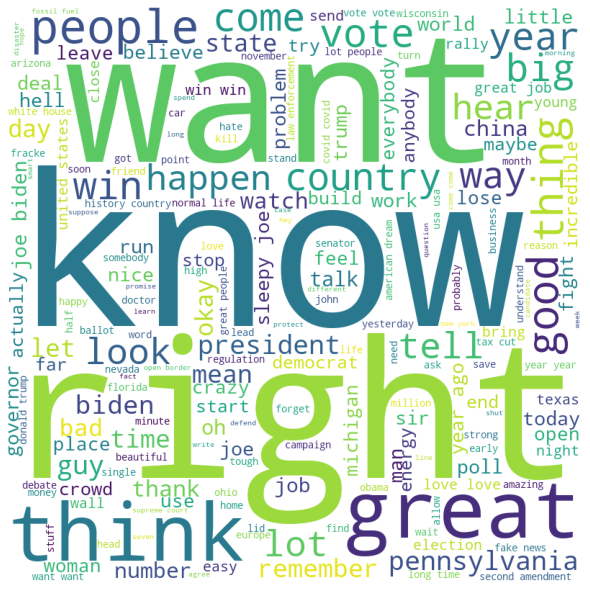

In [44]:
# Wordcloud

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(corpus_text) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [46]:
# t_SNE Plot

tsne_model = TSNE(n_components=2, verbose=1, random_state=7, angle=.99, init=’pca’)
# 13-D -> 2-D
tsne_lda = tsne_model.fit_transform(H) # doc_topic is document-topic matrix from LDA

SyntaxError: invalid character in identifier (<ipython-input-46-017aca7b55a1>, line 3)